In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import http.client
from urllib.parse import urlparse
import re
import subprocess
import socket
import os
import sys
import requests

O objetivo do meu trabalho é realizar testes e avaliar os níveis de segurança dos sites das universidades federais. Para isso, separei meu trabalho em quatro seções diferentes, analisando a presença de um certificado SSL, se possui servidor próprio ou terceiro (se sim, qual), se ele possui WAF ou não e o ISP dele. 

Possuir um certificado SSL significa que o site da universidade possui um certificado de segurança, que é um arquivo de dados que vincula uma chave criptográfica a informações de uma organização.

Ter um servidor próprio significa que o site da universidade está hospedado em um servidor que pertence a ela, enquanto ter um servidor terceiro significa que o site está hospedado em um servidor que não pertence a universidade. Ter WAF significa que o site possui um firewall de aplicação web, que é um sistema de segurança que monitora, filtra e bloqueia o tráfego HTTP para e de um aplicativo da Web. E ISP é o provedor de serviços de internet, que é a empresa que fornece acesso à internet para a universidade.

Embora os conceitos de ISP e servidor terceiro são muito parecidos, para este caso eu os separei em duas seções diferentes, pois o ISP é a empresa que fornece acesso à internet para a universidade, enquanto o servidor terceiro é a empresa que hospeda o site da universidade.

### IP dos sites

Para verificar o IP dos sites, eu utilizei a biblioteca `socket` do Python para fazer uma requisição DNS para o site e verifiquei se o código de status da resposta é 0, o que significa que a requisição foi bem sucedida. Se a requisição não for bem sucedida, o código de status será diferente de 0 e o site não possui um IP válido.

O IP não foi pedido, mas pode vir a ser um auxiliar importante no projeto.

In [18]:
import requests
import socket
from urllib.parse import urlparse

# Abra o arquivo .txt e leia cada linha
with open('universities.txt', 'r') as file:
    sites = file.read().splitlines()

ips = []

# Abra (ou crie) um arquivo para armazenar os IPs
with open('universities_ips.txt', 'w') as output:
    # Para cada site na lista, obtenha o IP
    for site in sites:
        try:
            # Extrai o nome do domínio
            domain = urlparse(site).netloc
            ip = socket.gethostbyname(domain)
            ips.append(ip)
            
            # Escreve o nome da universidade e o IP no arquivo
            output.write(f'{domain} - {ip}\n')
        except socket.gaierror:
            continue

## Sites com SSL

O certificado SSL é um protocolo de segurança que cria uma ligação segura entre o servidor web e o navegador. Certificar-se de que um site tem um Certificado SSL válido é outra maneira de avaliar a segurança de um site. 

A presença de um Certificado SSL válido é um forte indicador da segurança de um site. Ele garante que a identidade do site é autêntica, protegendo os usuários contra ataques de "man-in-the-middle", onde os cibercriminosos podem interceptar e manipular os dados transmitidos.

Para verificar se um site possui um Certificado SSL válido, eu utilizei a biblioteca `requests` do Python para fazer uma requisição GET para o site e verifiquei se o código de status da resposta é 200, o que significa que a requisição foi bem sucedida. Se a requisição não for bem sucedida, o código de status será diferente de 200 e o site não possui um Certificado SSL válido.

In [13]:
def verify_ssl(site):
    try:
        response = requests.get(site, timeout=5)
        if response.url.startswith('https://'):
            return True
    except (requests.exceptions.SSLError, requests.exceptions.RequestException):
        pass
    return False

# Abra o arquivo .txt e leia cada linha
with open('universities.txt', 'r') as file:
    sites = file.read().splitlines()

ssl_count = 0
non_ssl_count = 0

sites_with_ssl = []

# Para cada site na lista, obtenha o IP e verifique o certificado SSL
for site in sites:
    try:
        # Extrai o nome do domínio
        domain = urlparse(site).netloc
        ip = socket.gethostbyname(domain)
        
        # Verifique o certificado SSL
        if verify_ssl(site):
            ssl_count += 1
            sites_with_ssl.append(site)
        else:
            non_ssl_count += 1
    except socket.gaierror:
        continue

print(f"Sites with SSL: {ssl_count}")
print(f"Sites without SSL: {non_ssl_count}")

# Salve os sites com SSL em um novo arquivo
with open('universities_with_ssl.txt', 'w') as file:
    for site in sites_with_ssl:
        file.write(site + '\n')


Sites with SSL: 74
Sites without SSL: 34


## Análise de servidores

O servidor é o computador que hospeda o site da universidade. Ele pode ser próprio ou terceiro. Ter um servidor próprio significa que o site da universidade está hospedado em um servidor que pertence a ela, enquanto ter um servidor terceiro significa que o site está hospedado em um servidor que não pertence a universidade. 

Para verificar se o site possui um servidor próprio ou terceiro, eu utilizei a biblioteca `requests` do Python para fazer uma requisição GET para o site e verifiquei se o código de status da resposta é 200, o que significa que a requisição foi bem sucedida. Se a requisição não for bem sucedida, o código de status será diferente de 200 e o site possui um servidor terceiro. 

In [20]:
def obter_informacoes_servidor(url):
    url_parseada = urlparse(url)
    try:
        conexao = http.client.HTTPSConnection(url_parseada.netloc, timeout=5) if url_parseada.scheme == 'https' else http.client.HTTPConnection(url_parseada.netloc, timeout=5)
        conexao.request("HEAD", url_parseada.path)

        resposta = conexao.getresponse()
        servidor = resposta.getheader('Server')
        localizacao = resposta.getheader('Location')

    except (http.client.HTTPException, OSError):
        return None, None

    finally:
        conexao.close()

    return servidor, localizacao

# Lendo a lista de URLs do arquivo
with open('universities.txt', 'r') as arquivo:
    urls = [url.strip() for url in arquivo]

# Criando um arquivo de saída para as informações do servidor
with open('info_servidores.txt', 'w') as saida:
    for url in urls:
        servidor, localizacao = obter_informacoes_servidor(url)

        if servidor and localizacao:
            info = f"URL: {url}\nServidor: {servidor}\nLocalização: {localizacao}\n\n"
            saida.write(info)

Ainda nesta seção fiz um estudo com a quantidade de sites que estão hosted em cada tipo de servidor terceiro. Os servidores terceiros mais comuns são o Cloudflare, o Akamai-NGINX e o Amazon. 

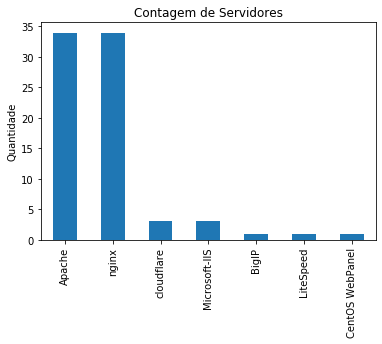

In [5]:
# Carregue o arquivo em um DataFrame do pandas
df = pd.read_csv('info_servidores.txt', sep="\n", header=None)

# Filtrando as linhas que contêm a informação do servidor
df = df[df[0].str.startswith('Servidor:')]

# Extraindo o nome do servidor e contando as ocorrências
df['Servidor'] = df[0].apply(lambda x: re.split(r'[/:]', x.replace('Servidor: ', ''))[0])
contagem = df['Servidor'].value_counts()

# Gerando o gráfico de barras
contagem.plot(kind='bar')

plt.title('Contagem de Servidores')
plt.ylabel('Quantidade')

plt.show()

## Presença de WAF nos sites de universidades federais

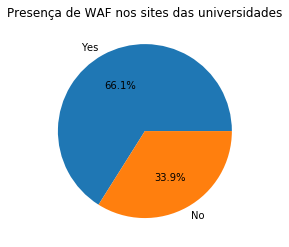

In [4]:
# Abra o arquivo .txt e leia cada linha
with open('universities.txt', 'r') as file:
    sites = file.read().splitlines()

# Dicionário para armazenar os resultados
results = {}

# Para cada site na lista, checamos a presença de um WAF
for site in sites:
    result = subprocess.run(['wafw00f', site], capture_output=True, text=True)
    if "No WAF detected" in result.stdout:
        results[site] = 'No'
    else:
        results[site] = 'Yes'

# Crie um gráfico de pizza com os resultados
waf_counts = {'Yes': list(results.values()).count('Yes'), 'No': list(results.values()).count('No')}
plt.pie(waf_counts.values(), labels=waf_counts.keys(), autopct='%1.1f%%')
plt.title('Presença de WAF nos sites das universidades')
plt.show()